# 人工知能・深層学習実験 第６・７回

コンピュータビジョンでは，人間が視覚を通して周囲の世界を認識するように，コンピュータによって自動的に画像や動画の持つ意味を認識することを目指します．  

今回の実験では，コンピュータビジョン分野の中で「人間には簡単だが機械には難しい」問題の例として半ばジョーク的に挙げられることの多い唐揚げ・プードル分類に挑戦しましょう．


参考：唐揚げとプードル以外にも，マフィンとチワワなどが有名です．  
https://front-row.jp/_ct/17135189

参考：実装にあたり，以下の記事を参考にしました．
https://qiita.com/katsujitakeda/items/f1842f5e831bb6475ba8

# 実験概要
実験は以下の流れで進めます．

1.   スクレイピングによる画像データの収集
2.   データセットの構築とデータの前処理
3.   畳み込みニューラルネットワークの構築
4.   画像分類の学習と評価
5.   1～3の改善による分類性能の向上
6.   分類性能のテスト

6のテストはコンペ形式で，2回目の最後に各自のモデルの分類性能を競ってもらいます．

# 0. 下準備
google colabで動作確認しています．
ローカル環境でうまく動かない場合は，colabに切り替えてみてください．

## 必要なライブラリのインストール

In [ ]:
# シェルコマンドを使用
!pip install icrawler
!pip install japanize_matplotlib

## 必要なライブラリのインポート

In [ ]:
# 基本的なライブラリ
import os
import glob
import random
import json
import numpy as np
import torch

# 画像のスクレイピング
from icrawler.builtin import GoogleImageCrawler # Google経由で画像を拾ってくるライブラリ

# 画像データの処理
import torchvision
from torchvision import transforms

# ネットワークの構築，学習
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import tqdm

# 可視化関連
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
import seaborn as sns

# Google driveのマウント (コンペで使用)
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## シードの固定

In [ ]:
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 1. スクレイピングによる画像データの収集

上でインポートした*GoogleImageCrawler*を使ってスクレイピングを実行し，指定したディレクトリに画像を保存します．

参考（icrawlerのドキュメント）: https://icrawler.readthedocs.io/en/latest/builtin.html

デフォルトでは，`'dataset'`というディレクトリ以下に各検索キーワードのディレクトリが作成され，その中に画像が保存されます (colab環境の場合，サイドバーの「ファイル」からファイル構成を確認できます)．

スクレイピング実行時のエラーは気にしなくて良いです．

演習 1.1:   以下のコードを実行し，実行結果を確認してみましょう．  

演習 1.2:   スクレイピングするキーワードや枚数を変更してみましょう．  

演習 1.3:   スクレイピング結果から気づいたことを議論してみましょう．

In [ ]:
# 画像のスクレイピング
def scrape_imgs(keywords, max_num, save_dir='dataset'):
    print('Scraping images...')
    for keyword in keywords.keys():
        if not os.path.exists(os.path.join(save_dir, keywords[keyword])):
            os.makedirs(os.path.join(save_dir, keywords[keyword]))
        crawler = GoogleImageCrawler(
          downloader_threads = 4,
          storage = {'root_dir' : os.path.join('tmp/', keywords[keyword])}
        )
        crawler.crawl(
            keyword = keyword,
            max_num = max_num,
            filters = dict(date = ((2020,1,1),(2023,12,31)))
        )
        # 拡張子をpngに統一
        for i, filename in enumerate(glob.glob(os.path.join('tmp', keywords[keyword], '*.jpg'))):
            img = Image.open(filename)
            img.save(filename.replace('.jpg', '.png').replace('tmp', save_dir))
    print(f'Done! Saved to {save_dir}')

In [ ]:
# スクレイピングするキーワードを定義
keywords = {'唐揚げ': 'karaage', 'トイプードル': 'poodle'} # 2クラス分類
# keywords = {'唐揚げ': 'karaage', 'トイプードル': 'poodle', 'コロッケ': 'croquette', 'オールドファッション': 'oldfashion', 'レッサーパンダ': 'redpanda', 'タワシ': 'scrubber'} # 多クラス分類

# スクレイピングを実行
max_num = 10 # 各キーワードの画像を最大で何枚集めたいか（実際にはエラーで取得に失敗するものがある）
!rm -rf dataset
scrape_imgs(keywords, max_num)
!rm -rf tmp # 一時保存先を消去

Scraping images...


ERROR:downloader:Exception caught when downloading file https://www.nichireifoods.co.jp/media/wp-content/uploads/2023/02/2302_03_karaage_01.jpg, error: HTTPSConnectionPool(host='www.nichireifoods.co.jp', port=443): Max retries exceeded with url: /media/wp-content/uploads/2023/02/2302_03_karaage_01.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)'))), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://www.nichireifoods.co.jp/media/wp-content/uploads/2023/02/2302_03_karaage_01.jpg, error: HTTPSConnectionPool(host='www.nichireifoods.co.jp', port=443): Max retries exceeded with url: /media/wp-content/uploads/2023/02/2302_03_karaage_01.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)'))), remaining retry times: 1
ERROR:down

Done! Saved to dataset


# 2. データセットの構築とデータの前処理

*PyTorch*では*Dataset*クラスが定義されており，その*Datase*tクラスを継承した新たなクラスを定義することで独自のデータセットを構築することができます．

ここでは，スクレイピングで収集した画像データを用いて画像分類のためのデータセットを構築してみましょう．

演習 2.1:   下記のコードがエラーなく実行できることを確かめてください．  

演習 2.2:   `len()`, `show_img()`などのメソッドを実行し，結果を確認してみましょう．

演習 2.3:   配布資料では前処理として画像のリサイズと画素値の正規化を行っていますが，`transform_img()`に様々な前処理を追加することでデータセットを水増し（*augmentation*）することもできます．`RandomRotation()`などのメソッドを試し，前処理によって画像の可視化結果がどうなるかを確認してください．

参考（PyTorchドキュメント）: https://pytorch.org/vision/main/transforms.html

In [ ]:
#データセットの構築
class Dataset(torch.utils.data.Dataset):
    def __init__(self, class_names, img_size, img_dir='dataset/'):
        self.classes = class_names
        self.class_name_list = list(self.classes.keys())
        self.label_map = {v: k for k, v in enumerate(self.classes)} # 各クラス名にIDを紐づける
        self.img_dir = img_dir
        self.img_size = img_size
        self.resize = transforms.Resize(self.img_size)
        self.img_paths, self.labels = self.make_dataset() # 各画像データの保存先とクラス名を取得する
        self.img_paths, self.labels = self.filter_dataset() # 不適切なデータを除外し，データ形式を統一

    def make_dataset(self):
        """
        classes: dict
        img_dir: path to dataset
        """
        print('Making dataset...', end='')
        img_paths = []
        labels = []
        for class_name, class_dir in self.classes.items():
            class_imgs = glob.glob(os.path.join(self.img_dir, class_dir, '*.png')) # 画像を読み出す
            img_paths.extend(class_imgs)
            labels.extend([self.label_map[class_name]] * len(class_imgs)) # クラス名に対応するIDを付与
        print('Done!')
        return img_paths, labels

    def filter_dataset(self):
        """
        if any image is not RGB, remove it from dataset
        img_paths: list
        labels: list
        """
        print('Filtering dataset...', end='')
        # RGB画像でないものが混じることがあるため，除去する
        for i, img_path in enumerate(self.img_paths):
            img = Image.open(img_path, mode='r')
            if img.mode != 'RGB':
                self.img_paths.pop(i)
                self.labels.pop(i)
        print('Done!')
        return self.img_paths, self.labels

    def __len__(self): # データセットのサイズを定義するためのメソッド．必須．
        return len(self.img_paths)

    def read_img(self, idx):
        # 画像の読み込み
        img_path = self.img_paths[idx]
        img = Image.open(img_path, mode='r') # mode: RGB
        img = torch.Tensor(np.array(img))

        # 画像のサイズを統一
        if img.shape[0] != 3: # チャネル数が最後に来ている場合に対処
            img = img.permute(2, 0, 1)
        if img.shape[0] != 3: # チャネル数が3でない場合に対処
            img = img[:3]
        return img, img_path

    def __getitem__(self, idx): # データセットの要素を取得する際の処理を示すメソッド．必須．
        img, img_path = self.read_img(idx) # 画像の読み込み
        img = self.resize(img)

        # 各データのラベルをone-hotベクトルとして表現
        label = F.one_hot(torch.tensor(self.labels[idx]), num_classes=len(self.classes))

        return img, label, img_path

    # データセット内の画像を可視化
    def show_img(self, idx, resize, transform, pred=''):
        """
        idx: int
        pred: str
        """
        img_path = self.img_paths[idx]
        img = Image.open(img_path, mode='r') # mode: RGB

        # resizeを可視化に反映する
        if resize:
            img = img.resize(self.img_size)

        # transformを可視化に反映する
        if transform:
            img = torch.Tensor(np.array(img)).permute(2,0,1)
            img = CollateFn(transform=True).transform_img(img)
            img = img.permute(1,2,0).to(torch.int)

        label = self.class_name_list[self.labels[idx]]
        if pred:
            plt.title(f'Label: {label} Pred: {pred}')
        else:
            plt.title(f'Label: {label}')
        plt.imshow(img)

class CollateFn:
    def __init__(self, transform=False):
        self.transform = transform

    def __call__(self, batch):
        """
        batch: list
        """
        if self.transform:
            return self.collate_fn_train(batch)
        else:
            return self.collate_fn_val(batch)

    def collate_fn_train(self, batch):
        """
        batch: list
        """
        images, labels, paths = zip(*batch)
        images = torch.stack(images)
        images = self.transform_img(images)

        labels = torch.stack(labels)

        return images, labels, paths

    # 画像の前処理．Composeの中にメソッドを追加することで処理を追加可能
    def transform_img(self, img):
        """
        img: torch.Tensor
        """
        transform = transforms.Compose(
            [
                # 画素値の正規化．平均と分散の値はImageNetデータセットの値に準じる．
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
                ## ここに新たな前処理を追加 ##
            ])
        return transform(img)

    def collate_fn_val(self, batch):
        """
        batch: list
        """
        images, labels, paths = zip(*batch)
        images = torch.stack(images)
        images = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])(images)
        labels = torch.stack(labels)

        return images, labels, paths

Making dataset...Done!
Filtering dataset...Done!
Class num: 2


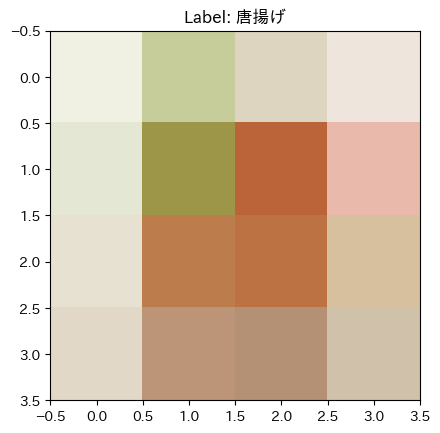

In [ ]:
# データセットの作成
img_size = (4, 4)
dataset = Dataset(class_names=keywords, img_size=img_size)
class_num = len(dataset.classes)
print(f'Class num: {class_num}')
len(dataset)
dataset.label_map
dataset.class_name_list
dataset.show_img(idx=2, resize=True, transform=False)

# 3. 畳み込みニューラルネットワークの構築
コンピュータビジョン分野では，ニューラルネットワークの中でも**畳み込みニューラルネットワーク**（*CNN; Convolutional Neural Network*）と呼ばれるものが多く使われています． これは人間の視覚機能をヒントに発明されたもので，畳み込み（下記のコードでは`Conv2d()`）とプーリング（下記のコードでは`max_pool2d()`）と呼ばれる処理を繰り返すことで画像中の様々なパターンを捉えます．

まずは，下記のシンプルなCNNを使って画像からクラスを分類してみましょう．

演習 3.1: 下記のコードがエラーなく実行できることを確かめてください．  

演習 3.2: 実行すると，データセット内の一つ目のデータに対するCNNの出力結果が表示されます．この出力は何を意味していますか？  

演習 3.3: コードの中では，`Conv2d()`や`max_pool2d()`に`kernel_size`や`padding`といったオプションが設定されています．これらの意味や，他にオプションがどんなオプションがあるかを調べてみましょう．また，これらのオプションを変更しても問題なく動作するようにインスタンス変数を定義してみましょう．

**ヒント：畳み込み層の前後で，入出力の次元の関係は以下の式を満たします（参考: https://qiita.com/DeepTama/items/379cac9a73c2aed7a082 ）．**

**出力サイズ =｛(入力サイズ + 2 × パディングサイズ - フィルタサイズ) / ストライドサイズ｝+ 1**

演習 3.4: 下記のコードのCNNは，畳み込みとプーリングを2回ずつ行います．ここにコードを書き加え，畳み込みとプーリングをもう1回ずつ実行するように変更してみてください．


In [ ]:
class CNN(nn.Module):
    def __init__(self, class_num, img_size):
        super(CNN, self).__init__()
        self.img_size = img_size
        self.conv1_outc = 4
        self.conv1 = nn.Conv2d(3, self.conv1_outc, kernel_size=3, padding=1, stride=1) # 3 チャネルの画像 → 4 チャネルへ

        self.conv1_outh = int((self.img_size[0] + 2 * self.conv1.padding[0] - self.conv1.kernel_size[0])/self.conv1.stride[0] + 1)
        self.conv1_outw = int((self.img_size[1] + 2 * self.conv1.padding[1] - self.conv1.kernel_size[1])/self.conv1.stride[1] + 1)

        self.pool1_size = 2

        self.conv2_outc = 3
        self.conv2 = nn.Conv2d(self.conv1_outc, self.conv2_outc, kernel_size=3, padding=1, stride=1) # 4 チャネルの画像 → 3 チャネルへ
        self.conv2_outh = int((int(self.conv1_outh/self.pool1_size) + 2 * self.conv2.padding[0] - self.conv2.kernel_size[0])/self.conv2.stride[0] + 1)
        self.conv2_outw = int((int(self.conv1_outw/self.pool1_size) + 2 * self.conv2.padding[1] - self.conv2.kernel_size[1])/self.conv2.stride[1] + 1)

        self.pool2_size = 2
        self.fc1_in = self.conv2_outc * int(self.conv2_outh/self.pool2_size) * int(self.conv2_outw/self.pool2_size)
        self.fc1_out = 4
        self.fc1 = nn.Linear(self.fc1_in, self.fc1_out)
        self.fc2 = nn.Linear(self.fc1_out, class_num)

    def forward(self, x):
        batch_size = x.shape[0]
        x = F.tanh(self.conv1(x)) # 4 チャネルへ
        assert x.shape[2] == self.conv1_outh and x.shape[3] == self.conv1_outw, 'テンソルのサイズを正しく指定してください．'
        x = F.max_pool2d(x, kernel_size=self.pool1_size) # 画像の縦横が1/2倍に

        x = F.tanh(self.conv2(x)) # 2 チャネルへ
        assert x.shape[2] == self.conv2_outh and x.shape[3] == self.conv2_outw, 'テンソルのサイズを正しく指定してください．'
        x = F.max_pool2d(x, kernel_size=self.pool2_size) # 画像の縦横が1/2倍に

        x = x.view(batch_size, -1) # 特徴量をベクトル化
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)

        x = F.softmax(x, dim=1)
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(class_num, img_size) # CNNを初期化
model.to(device) # モデルをGPUまたはCPUに載せる

sample, label, path = dataset[0]
sample = sample.unsqueeze(0)
sample = sample.to(device)
print(sample.shape)
print(model(sample))

torch.Size([1, 3, 4, 4])
tensor([[0.5873, 0.4127]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


# 4. 画像分類の学習と評価
ここまででデータセットとモデルを構築できたので，いよいよモデルの学習に移ります．

今回の実験では2回目の最後にテストデータに対する分類性能を比較しますので，それまでは手元のデータを学習データと検証データに分割して使用します．

演習 4.1: 以前の講義では自分自身で学習データと検証データに分割しましたが，PyTorchには`random_split()`のようにデータセットの分割を自動で行うメソッドが存在します．これを使って，学習データと検証データを8:2の割合で分割してみましょう．

参考（PyTorchのドキュメント）: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

演習 4.2: 以前の講義資料を参考に，適切な損失関数と最適化手法を設定してみましょう．

演習 4.3: 以前の講義資料を参考に，モデルの出力結果から特定のクラスを予測結果に定め，その結果を基に検証データにおける正解率を算出してみましょう．

演習 4.4: 下記のコードがエラーなく実行できるようにしてください．

演習 4.5: 検証データの中で，予測に成功した画像と失敗した画像をそれぞれ可視化してみましょう．何か傾向は見られるでしょうか．

In [ ]:
def train(bar, model, train_loader, criterion, optimizer, epoch, device):
    model.train()
    epoch_loss = 0
    samples = 0
    for i, (images, labels, paths) in enumerate(train_loader):
        images = images.to(device)
        # print(images.shape) # (B, C, H, W)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # print(f"outputs: {outputs}")
        # print(f"labels: {labels}")
        loss = criterion(outputs, labels.to(torch.float))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        samples += images.shape[0]
        bar.set_description(f'Epoch {epoch+1} Train {samples/len(train_loader.dataset)*100:.0f}% Loss: {loss.item()/samples:.4f}')
    return epoch_loss/samples

def val(bar, model, val_loader, criterion, epoch, device):
    model.eval()
    epoch_loss = 0
    samples = 0
    TP = 0
    for i, (images, labels, paths) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.to(torch.float))
        pred = torch.argmax(outputs, dim=1)
        TP += torch.sum(pred == labels.argmax(dim=1)).item()
        epoch_loss += loss.item()
        samples += images.shape[0]
        accuracy = TP / samples
        bar.set_description(f'Epoch {epoch+1} Val {samples/len(val_loader.dataset)*100:.0f}% Loss: {loss.item()/samples:.4f}, Accuracy: {accuracy:.4f}')
    return epoch_loss/samples, accuracy

def report_result(result):
    # visualize the loss curve
    plt.figure()
    plt.plot(result['train'], label='train')
    plt.plot(result['val'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    # visualize the accuracy curve
    plt.figure()
    plt.plot(result['acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

Training...

Epoch 10 Val 100% Loss: 0.1733, Accuracy: 0.5000: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Done!


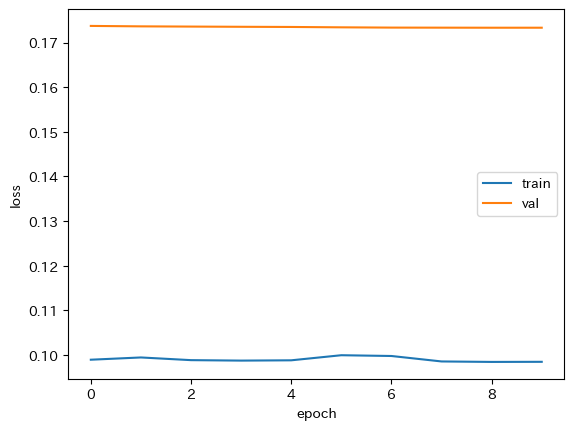

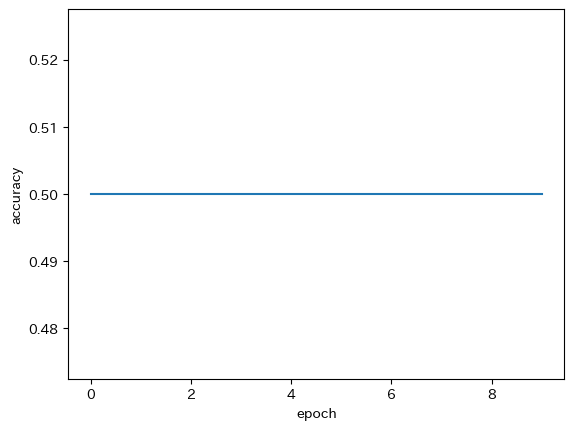

In [ ]:
# 学習データと開発データを分割
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# データローダーを定義
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False, num_workers=2, collate_fn=CollateFn(transform=True))
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False, drop_last=False, num_workers=2, collate_fn=CollateFn(transform=False))

criterion = nn.CrossEntropyLoss() # 損失関数の定義
optimizer = optim.SGD(model.parameters(), lr=1e-1) # 最適化手法の定義

num_epoch = 10
print('Training...', end='')
bar = tqdm.tqdm(range(num_epoch), leave=True)
result = {'train': [], 'val': [], 'acc': []}
for epoch in bar:
    train_loss = train(bar, model, train_loader, criterion, optimizer, epoch=epoch, device=device)
    result['train'].append(train_loss)
    val_loss, accuracy = val(bar, model, val_loader, criterion, epoch=epoch, device=device)
    result['val'].append(val_loss)
    result['acc'].append(accuracy)
print(f'Done!')

torch.save(model.state_dict(), 'model.pth') # モデルを保存する
report_result(result) # 学習中の性能の推移を可視化

# 5. 分類性能の向上
ここまでで，データの収集，前処理，モデルの構築，モデルの学習を経て分類性能を評価することができました．最終的に得られるモデルの分類性能は，これらすべてに左右されて決まります．ここからは，これまでに実装してきた内容に独自に工夫を加え，分類性能の向上を目指してください．

演習 5.1: 収集したデータの中に，学習に悪影響を与えそうなものはありませんか．そのような画像をデータセットから除いたり，収集するデータを増やしたりするとどうなりますか．

演習 5.2: 前処理を変更することで性能がどのように変化するか確認しましょう．前処理にも適切なものとそうでないものがあります．

演習 5.3: モデルの構成を見直し，性能を向上させてみましょう．層を増やすだけでなく，活性化関数などの種類も見直しましょう．

演習 5.4: 学習条件を見直し，性能を向上させてみましょう．最適化手法や学習のエポック数など，調整できる点が多々あります．

演習 5.5: 唐揚げとプードルの分類でaccuracy 1.0 を達成しましょう．達成出来たらノートブック上部の`keywords`を多クラス分類に切り替え，そちらの性能向上を目指してください．

発展 5.6: モデルの予測結果に何か傾向がないか調べてみましょう．予測に成功/失敗した画像を可視化したり，クラスごとの正解率などの統計量を算出したりといった手があります．

発展 5.7: 深層学習では，過学習と呼ばれる問題がよく発生します．過学習されたモデルはトレーニングデータに対して過剰にフィットし（答えの丸暗記のようなもの），トレーニングデータに対する性能は向上しますが検証データやテストデータに対する性能が悪化します．過学習の対策方法について調べてみましょう．学習データのバリエーションを増やすことはその一つです．

発展 5.8: CNNに限らずよく用いられる強力なテクニックに残差接続（*residual connection*）というものがあるので，興味がある人は調べて実装してみると良いでしょう．

参考（残差接続の解説と実装）: https://euske.github.io/introdl/lec8/index.html

# 6. 分類性能のテスト
２回目の最後には，コンペ形式で各自のモデルの分類性能を評価します．
テスト時には「唐揚げ，プードル，コロッケ，オールドファッション，レッサーパンダ，タワシ」を含んだテストデータに対して予測するので，下記の`keywords`を使ってスクレイピングと学習を実行してください．

下記のコードでは，model.pathに保存したモデルを用いて，指定したディレクトリ内の画像クラスを予測します．予測結果は予測対象の画像のpathとともに`pred.json`に保存されるようになっています．

コンペの注意点：
- 学習データ，検証データともに自由に増やして構いません（ただしスクレイピングの日付は変更せず，配布資料のままに統一してください）．
- キーワードには下記の多クラス版の`keywords`を使用してください．
- 学習後のモデルは保存しておき，下記のコードを実行するだけで`pred.json`が得られるようにしてください．
- torchvisionなどが提供するpretrained modelの使用は認めます．

In [ ]:
# keywords = {'唐揚げ': 'karaage', 'トイプードル': 'poodle', 'コロッケ': 'croquette', 'オールドファッション': 'oldfashion', 'レッサーパンダ': 'redpanda', 'タワシ': 'scrubber'}

def inference(model, device, keywords, img_dir):
    class_names = list(keywords.keys()) # 予測結果からクラス名を逆引きするためのリスト
    pred_json = {}
    model.eval()
    print('Processing...')
    bar = tqdm.tqdm(glob.glob(os.path.join(img_dir, '*.png')), leave=True, desc='Processed 0 images')
    if len(bar) == 0:
        raise ValueError('No img in img_dir')
    with torch.no_grad():
        for i, img_path in enumerate(bar):
            img = Image.open(img_path, mode='r') # mode: RGB
            img = torch.Tensor(np.array(img))

            # 画像のサイズを統一
            if img.shape[0] != 3: # チャネル数が最後に来ている場合に対処
                img = img.permute(2, 0, 1)
            if img.shape[0] != 3: # チャネル数が3でない場合に対処
                img = img[:3]

            # 推論時の前処理
            img = transforms.Resize(img_size)(img)
            img = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])(img)

            img = img.unsqueeze(0)
            img = img.to(device)
            outputs = model(img)
            pred = torch.argmax(outputs, dim=1).item()
            pred_json[img_path] = pred
            bar.set_description(f'{i+1} th image: {class_names[pred]}')

    return pred_json

model = CNN(class_num, img_size)
model.load_state_dict(torch.load('model.pth'))
model.to(device)
pred_json = inference(model, device, keywords, img_dir='dataset/poodle')
# save json
save_path = 'pred.json'
with open(save_path, 'w') as f:
    json.dump(pred_json, f)

print(f'\nDone! json file was saved to {save_path}')

Processing...


9 th image: 唐揚げ: 100%|██████████| 9/9 [00:00<00:00, 38.07it/s]


Done! json file was saved to pred.json
